In [1]:
import math
import json
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
# from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
# import tensorflow as tf
from tqdm import tqdm
from matplotlib import rc
from pylab import rcParams
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
%matplotlib inline
%config InlineBackend. figure_format='retina'
sns.set(style='darkgrid', palette='muted', font_scale=1.2, rc={"axes.facecolor": "#2E2E2E", "axes.grid": True, "grid.color": "#333333", "axes.edgecolor": "#424242"})
color_pal = ['#FF6E40', '#FFEA00', '#1DE9B6', '#00E5FF', '#D500F9']
sns.set_palette(sns.color_palette(color_pal))
rcParams['figure.figsize' ] = 14, 7
rcParams['text.color'] = 'black'       # Titles and text
rcParams['axes.labelcolor'] = 'white'  # Axis labels
rcParams['xtick.color'] = 'black'      # X-axis tick labels
rcParams['ytick.color'] = 'black'
tqdm. pandas ()

In [3]:
train_df_scaled = pd.read_csv("Dataset/Alibaba/test.csv")
val_df_scaled = pd.read_csv("Dataset/Alibaba/val.csv")
test_df_scaled = pd.read_csv("Dataset/Alibaba/test.csv") 

In [4]:
train_df_scaled.shape, val_df_scaled.shape, test_df_scaled.shape # 1999990

((6877630, 13), (6877629, 13), (6877630, 13))

In [5]:
train_df_scaled=train_df_scaled[-(int)(len(train_df_scaled)/10):]
val_df_scaled=val_df_scaled[:(int)(len(test_df_scaled)/10)]
test_df_scaled=test_df_scaled[:(int)(len(test_df_scaled)/10)]
train_df_scaled.shape, val_df_scaled.shape, test_df_scaled.shape

((687763, 13), (687763, 13), (687763, 13))

In [6]:
train_df_scaled.columns

Index(['hour', 'minute', 'second', 'day', 'weekday', 'cpu_util_percent',
       'mem_util_percent', 'mem_gps', 'mkpi', 'net_in', 'net_out',
       'disk_io_percent', 'cpu_difference'],
      dtype='object')

In [36]:
timesteps = 59 # Define timesteps: for nxn window choose 2n-1 
columns_to_scale = ['hour', 'minute', 'second', 'day', 'weekday', 'cpu_util_percent',
       'mem_util_percent', 'mem_gps', 'mkpi', 'net_in', 'net_out',
       'disk_io_percent', 'cpu_difference']

forecast_horizon = 10  # Number of future steps to predict

def create_sequences(data, timesteps, target_idx, horizon):
    X, y = [], []
    for i in tqdm(range(timesteps, len(data) - horizon + 1)):
        X.append(data[i - timesteps:i])
        y.append(data[i:i + horizon, target_idx])  # Get next 30 values
    return np.array(X), np.array(y)

cpu_data = train_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_train, y_train = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences

cpu_data = val_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_val, y_val = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences

cpu_data = test_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_test, y_test = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences


100%|██████████| 687695/687695 [00:00<00:00, 2125804.35it/s]


In [37]:
features = X_train.shape[2]
features

13

In [38]:
# Prepare Data (Example: replace with actual dataset)
X_train = torch.tensor(X_train, dtype=torch.float32).clone().detach()
y_train = torch.tensor(y_train, dtype=torch.float32).clone().detach()
X_val = torch.tensor(X_val, dtype=torch.float32).clone().detach()
y_val = torch.tensor(y_val, dtype=torch.float32).clone().detach()
X_test = torch.tensor(X_test, dtype=torch.float32).clone().detach()
y_test = torch.tensor(y_test, dtype=torch.float32).clone().detach()

print(X_train.shape, y_train.shape)  # Should be (1000, timesteps, features) and (1000, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)  # No shuffling for test data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)  # No shuffling for test data

torch.Size([687695, 59, 13]) torch.Size([687695, 10])


In [39]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#### helpers

In [40]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch+1}")

In [41]:
# Function to load checkpoint
def load_checkpoint(model, optimizer, path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
        print(f"Checkpoint loaded: Resuming from epoch {start_epoch}")
        return start_epoch
    return 0  # If no checkpoint, start from epoch 0

In [42]:
# Function to compute validation loss
def evaluate_model_trianing(model, val_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            # y_batch = y_batch.view(-1, 1)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [43]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=10, checkpoint_interval=2, patience=5, path="checkpoints"):
    start_epoch = load_checkpoint(model, optimizer, path)
    model.train()
    print("#### TRAINING STARTED ####")

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    start_time = time.time()

    for epoch in range(start_epoch, epochs):
        model.train()
        running_train_loss = 0.0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss = evaluate_model_trianing(model, val_loader, loss_fn)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            save_checkpoint(model, optimizer, epoch, val_loss, path)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⚠️ Early stopping at epoch {epoch+1} (no improvement in val loss for {patience} epochs).")
            break

        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint(model, optimizer, epoch, val_loss, path)

    # Final stats
    total_time = round(time.time() - start_time, 2)
    print("\n#### TRAINING COMPLETE ####")
    print(f"Total Time Elapsed: {total_time} seconds")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val Loss: {val_losses[-1]:.4f}")

    # Plotting Loss Curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [44]:
# Function to load model from checkpoint
def load_model_from_checkpoint(model, checkpoint_path, device="cpu"):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Checkpoint loaded from {checkpoint_path}")
    else:
        print("No checkpoint found! Using randomly initialized model.")
    return model

In [45]:
def evaluate_model(model, test_loader, checkpoint_path, device="cpu"):
    model = load_model_from_checkpoint(model, checkpoint_path, device)
    model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    total_inference_time = 0.0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            start_time = time.perf_counter()
            y_pred = model(X_batch)
            end_time = time.perf_counter()

            batch_time = end_time - start_time
            total_inference_time += batch_time
            total_samples += X_batch.size(0)

            all_predictions.append(y_pred.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    predictions_np = np.concatenate(all_predictions, axis=0)
    y_test_np = np.concatenate(all_targets, axis=0)

    predictions_tensor = torch.tensor(predictions_np, dtype=torch.float32, device=device)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32, device=device)

    if predictions_tensor.shape != y_test_tensor.shape:
        print(f"⚠️ Shape mismatch! Predictions: {predictions_tensor.shape}, Targets: {y_test_tensor.shape}")
        y_test_tensor = y_test_tensor.view_as(predictions_tensor)

    mae = mean_absolute_error(y_test_np, predictions_np)
    rmse = np.sqrt(mean_squared_error(y_test_np, predictions_np))
    huber_loss = nn.HuberLoss()(predictions_tensor, y_test_tensor).item()
    mse_loss = nn.MSELoss()(predictions_tensor, y_test_tensor).item()

    avg_inference_time = (total_inference_time / total_samples) * 1000  # ms per sample

    print("\n##### Evaluation Metrics #####")
    print(f"Test MAE         : {mae:.4f}")
    print(f"Test RMSE        : {rmse:.4f}")
    print(f"Test Huber Loss  : {huber_loss:.4f}")
    print(f"Test MSE Loss    : {mse_loss:.4f}")
    print(f"Avg Inference Time per Sample: {avg_inference_time:.4f} ms")
    print(f"Total Evaluation Time        : {total_inference_time:.2f} seconds")

    # Plot Predicted vs Actual
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test_np.flatten()[0:1000], y=predictions_np.flatten()[0:1000], alpha=0.5, edgecolor=None)
    plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')  # Identity line
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs Actual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return mae, rmse, huber_loss, mse_loss, avg_inference_time


In [46]:
def print_model_summary(model):
    total_params = 0
    print(f"{'Layer':<40} {'Param Shape':<30} {'# Params'}")
    print("-" * 80)

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            total_params += param_count
            print(f"{name:<40} {str(list(param.shape)):<30} {param_count}")

    print("-" * 80)
    print(f"{'Total Trainable Params':<40} {'':<30} {total_params:,}")


#### proposed

In [47]:
class SE(nn.Module):
    def __init__(self, in_channels, ratio):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # squeeze
            nn.Conv2d(in_channels, in_channels//ratio, kernel_size=(1, 1)),  # compress
            nn.ReLU(),
            nn.Conv2d(in_channels//ratio, in_channels, kernel_size=(1, 1)),  # excitation
            nn.Sigmoid(),
        )

    def forward(self, X):
        return self.se(X)

class SENet(nn.Module):
    def __init__(self, in_channels, ratio):
        super().__init__()
        self.se = SE(in_channels, ratio)
        self.tanh = nn.Tanh()

    def forward(self, X):
        coef = self.se(X)
        X = X * coef
        return self.tanh(X)

class FourierTransformLayer(nn.Module):
    def forward(self, x):
        fft = torch.fft.fft2(x.to(torch.complex64))
        return torch.abs(fft)

class ReverseFramingLayer(nn.Module):
    def forward(self, x):
        batch_size, num_frames, frame_length, num_features = x.shape
        reconstructed = x[:, 0, :, :]
        last_elements = x[:, 1:, -1, :]
        return torch.cat([reconstructed, last_elements], dim=1)


In [48]:
class FramingLayer(nn.Module):
    def __init__(self, frame_length=30, frame_step=1):
        super(FramingLayer, self).__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step

    def forward(self, x):
        # Unfolding the input tensor in the time dimension (dimension 1)
        # x.shape = (batch_size, time_steps, channels)
        # The unfold method slides a window of length `frame_length` and step `frame_step`
        unfolded = x.unfold(dimension=1, size=self.frame_length, step=self.frame_step)
        
        # After unfolding, the shape will be (batch_size, num_windows, frame_length, channels)
        # Let's reorder the dimensions to get the desired shape:
        # (batch_size, num_windows, frame_length, channels) -> (batch_size, num_windows, frame_length, channels)
        # unfolded = unfolded.permute(0, 2, 1, 3)  # To make it (batch_size, frame_length, num_windows, channels)
        
        # Since the input is of size 64x59x9, you will get 30 windows for each input sequence (59 - 30 + 1 = 30)
        # Thus, reshaping to the final desired output shape (64, 30, 30, 9)
        return unfolded

In [53]:
class TimeSeriesModel(nn.Module):
    def __init__(self, timesteps, features):
        super(TimeSeriesModel, self).__init__()
        self.fft = FourierTransformLayer()
        self.framing = FramingLayer(frame_length=30, frame_step=1)
        self.reverse_framing = ReverseFramingLayer()
        
        # Stacked LSTMs with residual connections
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)  
        self.dropout = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.lstm4 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Equivalent to GlobalAveragePooling1D

        # Additional LSTM layers
        self.lstm5 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        
        self.dnn = nn.Sequential(
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )
        self.cnn = nn.Sequential(
            nn.Conv2d(features*2, 64, kernel_size=3, stride=(1, 1), padding='same'),  # Captures temporal patterns
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=1, stride=(1, 1), padding='same'),  # Extracts deeper features
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.AdaptiveAvgPool2d((30, 16))  # Standardizes feature size for SENet
        )

        self.senet = SENet(128, ratio=16)  # SENet should match CNN output channels
        self.senet2 = SENet(64, ratio=16)  # SENet should match CNN output channels

    
    def forward(self, X):
        X_freq = self.fft(X)
        X_freq = self.senet2(X_freq)
        X = torch.cat([X, X_freq], dim=-1)
        X = self.framing(X).permute(0, 2, 1, 3)
        X = self.cnn(X)
        X = self.senet(X)
        X = X.flatten(2).permute(0,2,1)
        
        X_res, _ = self.lstm1(X) # batch, seq_len, input_size
        X_res = self.dropout(X_res)
        X_res, _ = self.lstm2(X_res)
        X_res = self.dropout(X_res)
        X_res, _ = self.lstm3(X_res)


        X_res = self.dropout(X_res)
        X_lstm, _ = self.lstm4(X_res)
        
        cnn_output = self.global_avg_pool(X.permute(0, 2, 1)).squeeze(-1)  # (batch, features)
        X = X_lstm + cnn_output.unsqueeze(1)  # Broadcasting

        X, _ = self.lstm5(X)
        X = self.dropout(X)
        X, _ = self.lstm6(X)
        X = self.dropout(X)
        
        y = self.dnn(X[:, -1, :])
        return y

In [54]:
# Initialize model and move it to GPU
model = TimeSeriesModel(timesteps, features).to(device)
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# loss_fn = nn.HuberLoss(delta=1.0)
loss_fn = nn.MSELoss()
print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
lstm1.weight_ih_l0                       [256, 128]                     32768
lstm1.weight_hh_l0                       [256, 64]                      16384
lstm1.bias_ih_l0                         [256]                          256
lstm1.bias_hh_l0                         [256]                          256
lstm2.weight_ih_l0                       [128, 64]                      8192
lstm2.weight_hh_l0                       [128, 32]                      4096
lstm2.bias_ih_l0                         [128]                          128
lstm2.bias_hh_l0                         [128]                          128
lstm2.weight_ih_l0_reverse               [128, 64]                      8192
lstm2.weight_hh_l0_reverse               [128, 32]                      4096
lstm2.bias_ih_l0_reverse                 [128]                        

In [55]:
checkpoint_path = "ck_10/proposed_alibaba_lr=0.001.pth"

In [ ]:

train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

#### TRAINING STARTED ####


Epoch 1/100:  24%|██▍       | 2580/10745 [02:00<06:19, 21.49it/s]


KeyboardInterrupt: 

: 

In [ ]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_15896\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

TimeSeriesModel(
  (fft): FourierTransformLayer()
  (framing): FramingLayer()
  (reverse_framing): ReverseFramingLayer()
  (lstm1): LSTM(128, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(64, 32, batch_first=True, bidirectional=True)
  (lstm3): LSTM(64, 64, batch_first=True)
  (lstm4): LSTM(64, 128, batch_first=True)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (lstm5): LSTM(128, 64, batch_first=True)
  (lstm6): LSTM(64, 32, batch_first=True)
  (dnn): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=30, bias=True)
  )
  (cnn): Sequential(
    (0): Conv2d(26, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

C:\Users\User\AppData\Local\Temp\ipykernel_15896\1770941795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint loaded from ck/proposed_alibabalr=0.0001.pth


Evaluating: 100%|██████████| 10744/10744 [02:24<00:00, 74.44it/s]



##### Evaluation Metrics #####
Test MAE         : 0.0293
Test RMSE        : 0.0455
Test Huber Loss  : 0.0010
Test MSE Loss    : 0.0021
Avg Inference Time per Sample: 0.0259 ms
Total Evaluation Time        : 17.84 seconds


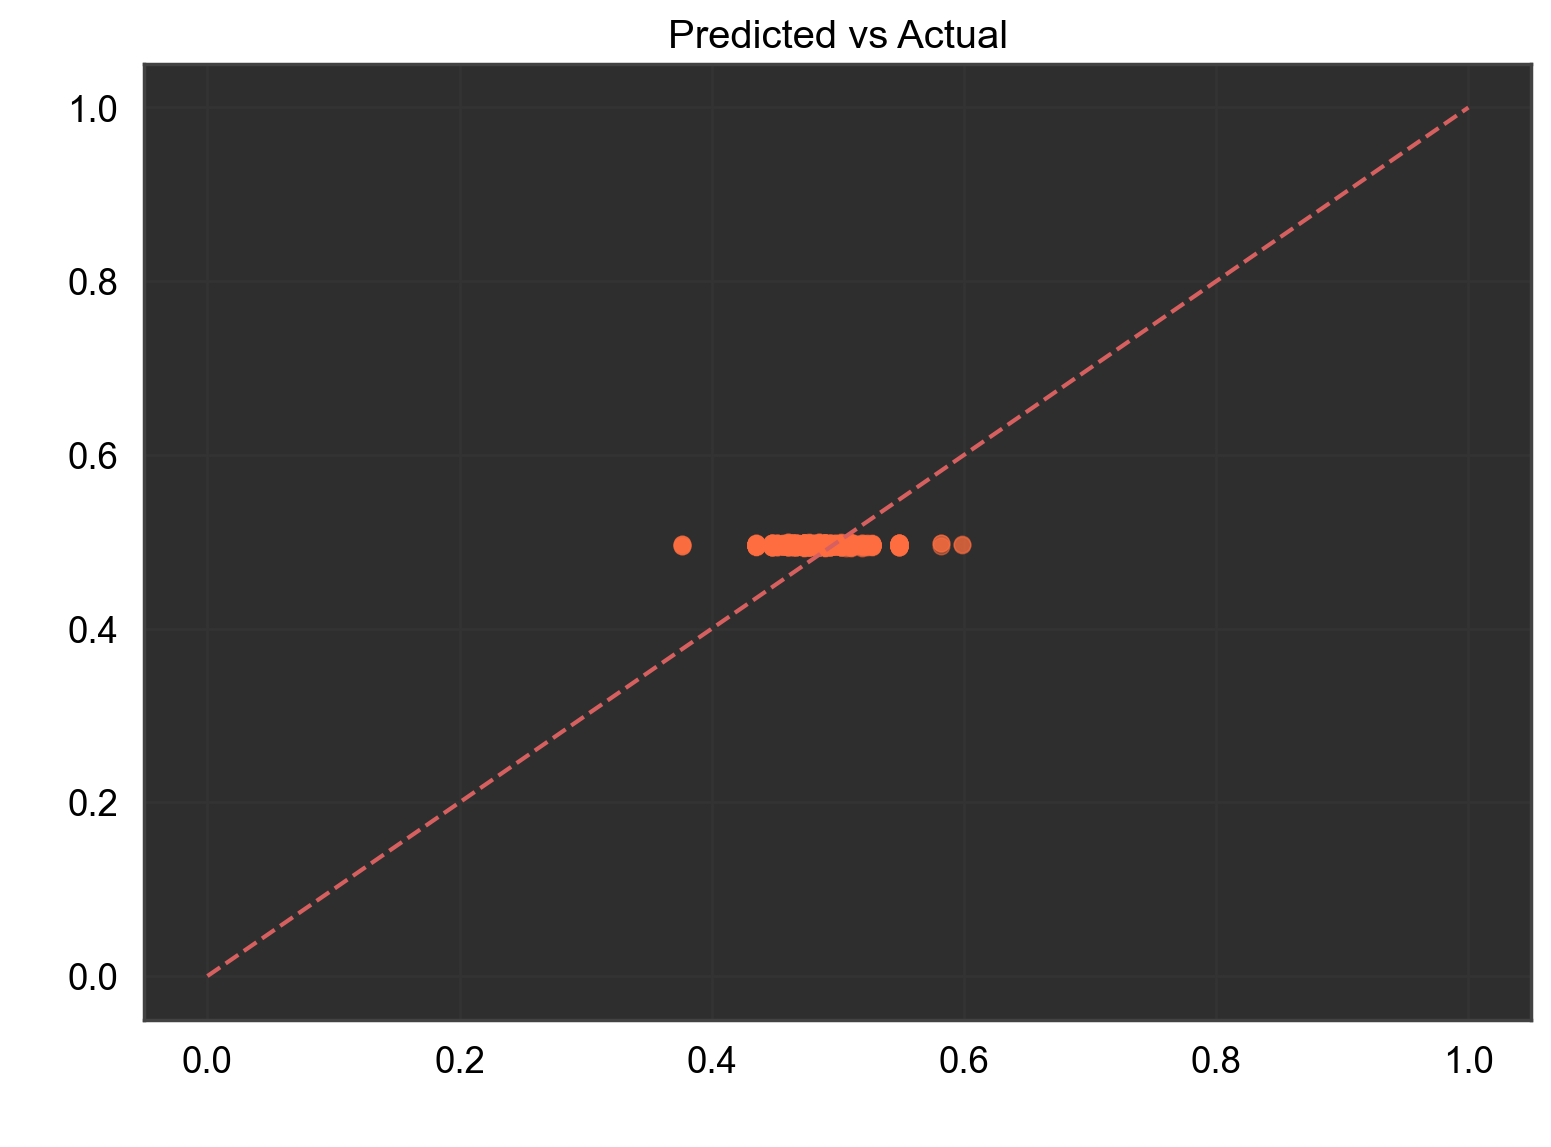

(0.029278920963406563,
 np.float64(0.045508887519745474),
 0.001035932800732553,
 0.002071865601465106,
 0.025947904352955825)

In [ ]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

#### T CNN SENet LSTM

In [31]:
class TimeSeriesModel_t(nn.Module):
    def __init__(self, timesteps, features):
        super(TimeSeriesModel_t, self).__init__()
        self.framing = FramingLayer(frame_length=30, frame_step=1)
        self.reverse_framing = ReverseFramingLayer()
        
        # Stacked LSTMs with residual connections
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)  
        self.dropout = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.lstm4 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Equivalent to GlobalAveragePooling1D

        # Additional LSTM layers
        self.lstm5 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        
        self.dnn = nn.Sequential(
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )
        self.cnn = nn.Sequential(
            nn.Conv2d(features, 64, kernel_size=3, stride=(1, 1), padding='same'),  # Captures temporal patterns
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=1, stride=(1, 1), padding='same'),  # Extracts deeper features
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.AdaptiveAvgPool2d((30, 16))  # Standardizes feature size for SENet
        )

        self.senet = SENet(128, ratio=16)  # SENet should match CNN output channels
        self.senet2 = SENet(64, ratio=16)  # SENet should match CNN output channels

    
    def forward(self, X):
        X = self.framing(X).permute(0, 2, 1, 3)
        X = self.cnn(X)
        X = self.senet(X)
        X = X.flatten(2).permute(0,2,1)
        
        X_res, _ = self.lstm1(X) # batch, seq_len, input_size
        X_res = self.dropout(X_res)
        X_res, _ = self.lstm2(X_res)
        X_res = self.dropout(X_res)
        X_res, _ = self.lstm3(X_res)


        X_res = self.dropout(X_res)
        X_lstm, _ = self.lstm4(X_res)
        
        cnn_output = self.global_avg_pool(X.permute(0, 2, 1)).squeeze(-1)  # (batch, features)
        X = X_lstm + cnn_output.unsqueeze(1)  # Broadcasting

        X, _ = self.lstm5(X)
        X = self.dropout(X)
        X, _ = self.lstm6(X)
        X = self.dropout(X)
        
        y = self.dnn(X[:, -1, :])
        return y

In [32]:
# Initialize model and move it to GPU
model = TimeSeriesModel_t(timesteps, features).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
lstm1.weight_ih_l0                       [256, 128]                     32768
lstm1.weight_hh_l0                       [256, 64]                      16384
lstm1.bias_ih_l0                         [256]                          256
lstm1.bias_hh_l0                         [256]                          256
lstm2.weight_ih_l0                       [128, 64]                      8192
lstm2.weight_hh_l0                       [128, 32]                      4096
lstm2.bias_ih_l0                         [128]                          128
lstm2.bias_hh_l0                         [128]                          128
lstm2.weight_ih_l0_reverse               [128, 64]                      8192
lstm2.weight_hh_l0_reverse               [128, 32]                      4096
lstm2.bias_ih_l0_reverse                 [128]                        

In [33]:
checkpoint_path = "ck/t_cnn_se_lstm_model_checkpoint_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 3580/3580 [02:19<00:00, 25.67it/s]


Epoch 01 | Train Loss: 0.0034 | Val Loss: 0.0033
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 3580/3580 [02:18<00:00, 25.79it/s]


Epoch 02 | Train Loss: 0.0023 | Val Loss: 0.0024
Checkpoint saved at epoch 2
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 3580/3580 [02:18<00:00, 25.90it/s]


Epoch 03 | Train Loss: 0.0021 | Val Loss: 0.0024


Epoch 4/100: 100%|██████████| 3580/3580 [02:18<00:00, 25.82it/s]


Epoch 04 | Train Loss: 0.0024 | Val Loss: 0.0027
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 3580/3580 [02:18<00:00, 25.84it/s]


Epoch 05 | Train Loss: 0.0029 | Val Loss: 0.0027


Epoch 6/100: 100%|██████████| 3580/3580 [02:23<00:00, 24.99it/s]


Epoch 06 | Train Loss: 0.0029 | Val Loss: 0.0027
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 3580/3580 [02:21<00:00, 25.22it/s]


Epoch 07 | Train Loss: 0.0029 | Val Loss: 0.0026


Epoch 8/100: 100%|██████████| 3580/3580 [02:22<00:00, 25.12it/s]


Epoch 08 | Train Loss: 0.0029 | Val Loss: 0.0026
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 3580/3580 [02:23<00:00, 24.87it/s]


Epoch 09 | Train Loss: 0.0029 | Val Loss: 0.0026


Epoch 10/100: 100%|██████████| 3580/3580 [02:23<00:00, 24.97it/s]


Epoch 10 | Train Loss: 0.0029 | Val Loss: 0.0026
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 3580/3580 [02:23<00:00, 24.93it/s]


Epoch 11 | Train Loss: 0.0029 | Val Loss: 0.0026


Epoch 12/100: 100%|██████████| 3580/3580 [02:23<00:00, 24.95it/s]


Epoch 12 | Train Loss: 0.0029 | Val Loss: 0.0027
⚠️ Early stopping at epoch 12 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 2261.39 seconds
Best Validation Loss: 0.0024
Final Train Loss: 0.0029
Final Val Loss: 0.0027


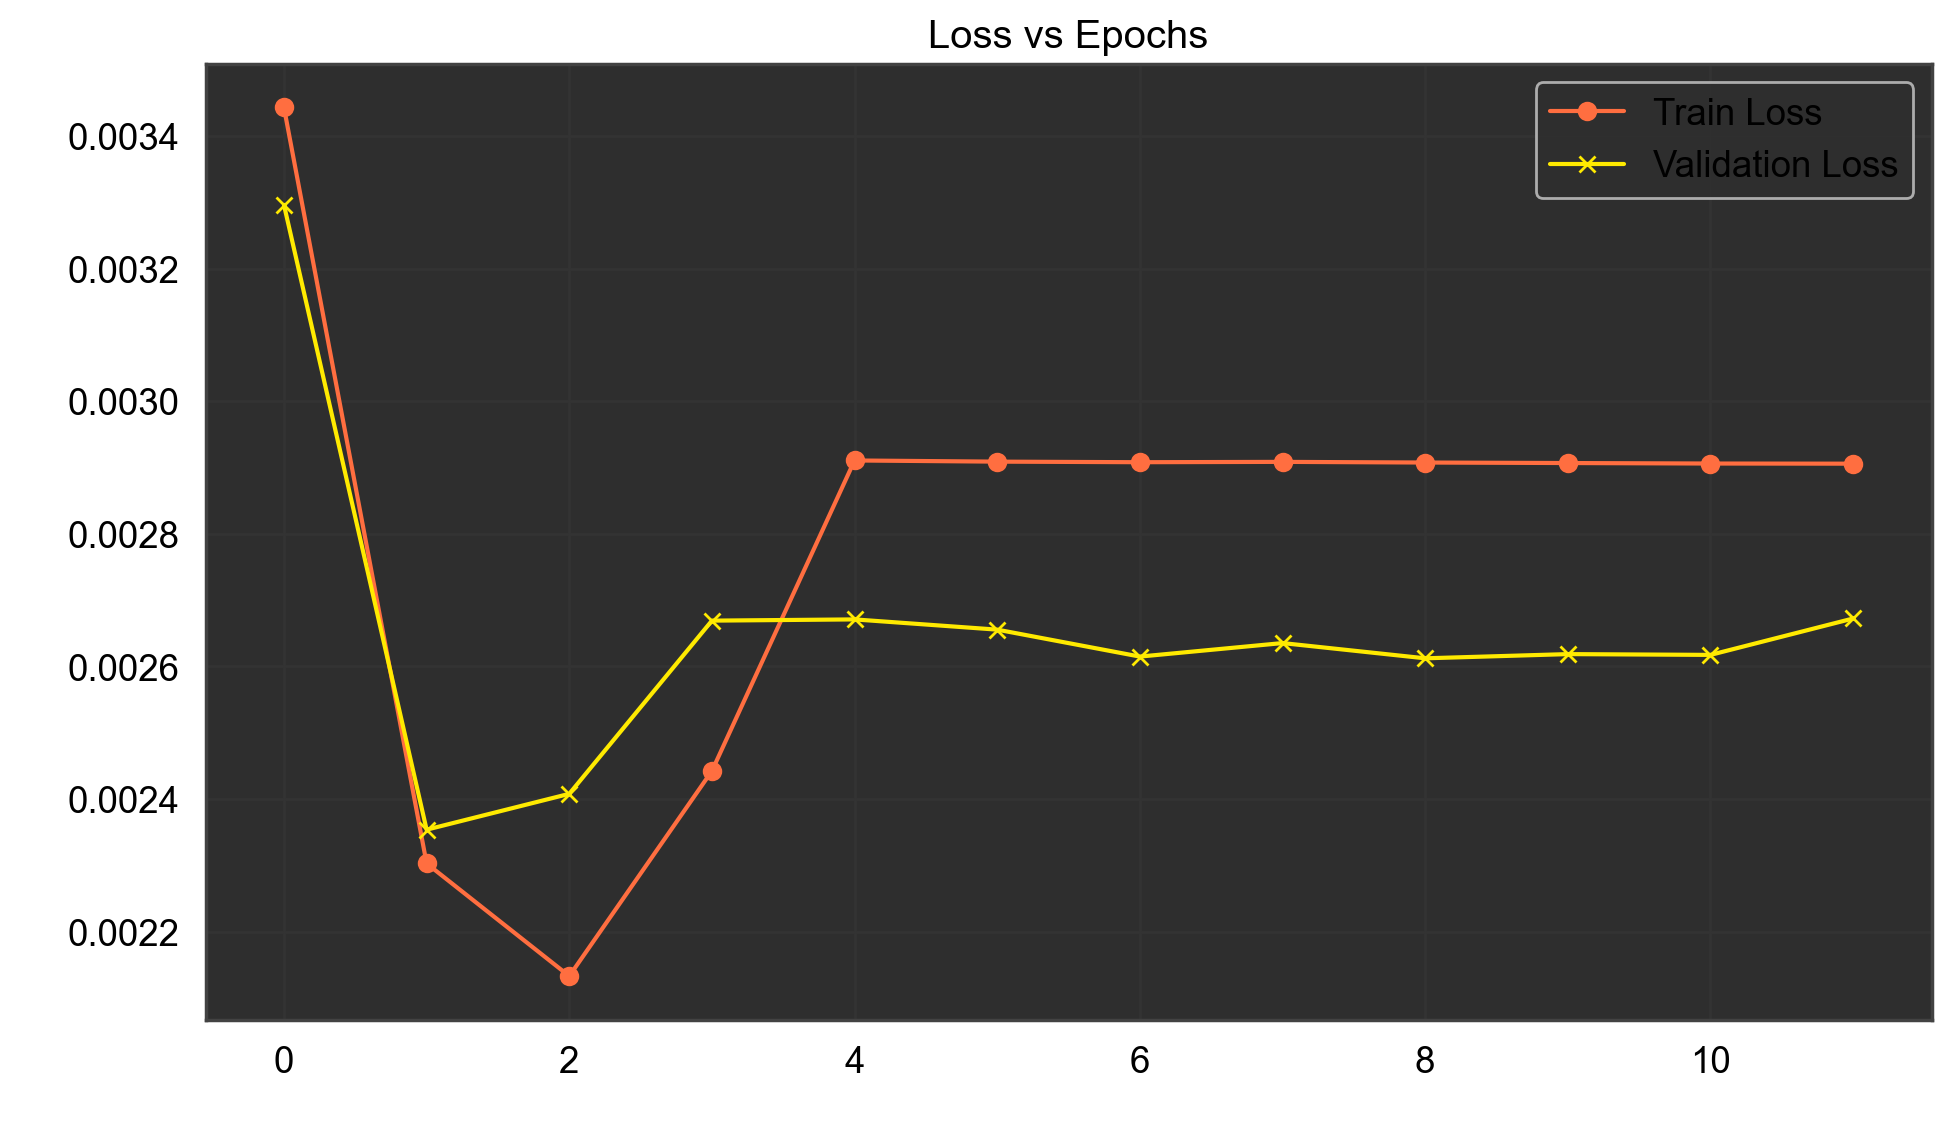

In [36]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [34]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_15896\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

TimeSeriesModel_t(
  (framing): FramingLayer()
  (reverse_framing): ReverseFramingLayer()
  (lstm1): LSTM(128, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(64, 32, batch_first=True, bidirectional=True)
  (lstm3): LSTM(64, 64, batch_first=True)
  (lstm4): LSTM(64, 128, batch_first=True)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (lstm5): LSTM(128, 64, batch_first=True)
  (lstm6): LSTM(64, 32, batch_first=True)
  (dnn): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=30, bias=True)
  )
  (cnn): Sequential(
    (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

C:\Users\User\AppData\Local\Temp\ipykernel_15896\1770941795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint loaded from ck/t_cnn_se_lstm_model_checkpoint_alibaba.pth


Evaluating: 100%|██████████| 10744/10744 [02:24<00:00, 74.53it/s]



##### Evaluation Metrics #####
Test MAE         : 0.0369
Test RMSE        : 0.0513
Test Huber Loss  : 0.0013
Test MSE Loss    : 0.0026
Avg Inference Time per Sample: 0.0248 ms
Total Evaluation Time        : 17.08 seconds


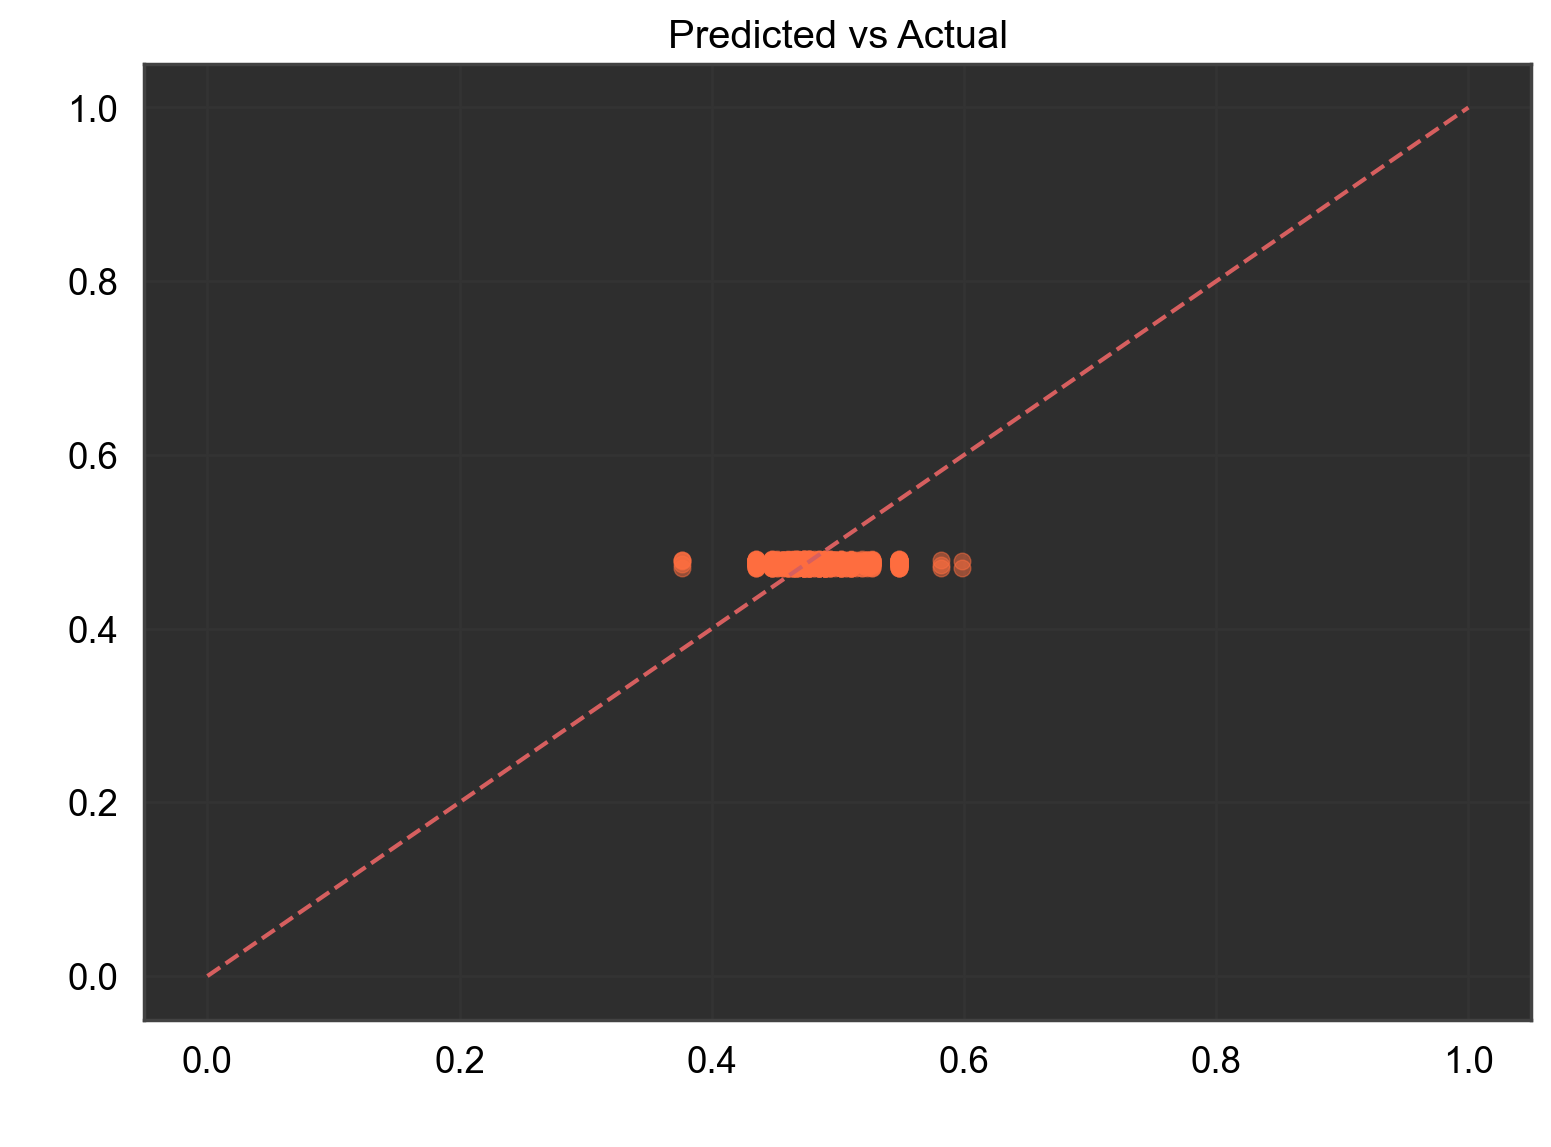

(0.03686796873807907,
 np.float64(0.05129492448746405),
 0.0013161267852410674,
 0.002632253570482135,
 0.024843617373468026)

In [35]:
evaluate_model(model, test_loader, checkpoint_path, device=device)